In [3]:
!pip install summa
#컴퓨팅 87.55

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54387 sha256=b850756604f5a452ddcbc67a39bed75bebaf5e09ace048ec910c4ecba571b719
  Stored in directory: /root/.cache/pip/wheels/4a/ca/c5/4958614cfba88ed6ceb7cb5a849f9f89f9ac49971616bc919f
Successfully built summa


In [4]:
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas as pd

print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

3.9.1
2.17.1
2.2.2
1.2.0


In [5]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print('=3')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


=3


Step 1. 데이터 수집하기


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import urllib.request
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Text_Summarization_11.26(화)/News_Summary-master/news_summary_more.csv', encoding='iso-8859-1')

In [7]:
data['Summary']=data['headlines']
data['Text']=data['text']

In [9]:
data.drop(['headlines','text'],axis=1,inplace=True)

In [10]:
data.sample(10)

,Summary,Text
44342,"Wherever Rahul Gandhi goes, Congress is decima...",Uttar Pradesh Chief Minister Yogi Adityanath o...
12058,Hearing in Salman's poaching case deferred to ...,Hearing on two appeals pertaining to two poach...
89083,2.3 lakh students to get free school uniforms ...,A total of 2.3 lakh students in Kerala would g...
87126,Akshay attends rumoured ex-girlfriend Pooja's ...,Actor Akshay Kumar on Sunday attended the scre...
66951,No nation lost as many troops as India fightin...,No nation has lost as many troops as India whi...
68178,Dubai starts testing world's first self-flying...,Dubai has started testing world's first two-se...
51304,32-year-old pregnant woman gangraped in Uttar ...,A 32-year-old pregnant woman was allegedly gan...
67772,"90,000 fewer infant deaths recorded in 2016 th...",The Ministry of Health and Welfare on Friday r...
13616,"UK visa fees to rise for Indian, non-EU immigr...",The overall fees for Indians and other non-Eur...
85191,Uber board member quits after making a sexist ...,Uber board member David Bonderman on Tuesday q...


Step 2. 데이터 전처리하기 (추상적 요약)


In [11]:
print('Text 열에서 중복을 배제하기 전 샘플의 수 :', len(data['Text']))
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())
# 큰 차이 없다

Text 열에서 중복을 배제하기 전 샘플의 수 : 98401
Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [12]:
data.drop_duplicates(subset = ['Text'], inplace=True) # 중복을 제거시켜주는 함수 drop_duplicates
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [13]:
print('null값 확인 :', data.isnull().sum())

null값 확인 : Summary    0
Text       0
dtype: int64


In [14]:
# 텍스트 정규화와 불용어 제거
"""살아남은 88,425개의 샘플에는 수많은 단어들이 있어요. 그런데 사실 그 단어들 중에서는 같은 의미인데도 다른 표현으로 쓰여 마치 다른 단어들처럼 간주되는 경우가 있어요.
예를 들어서 it'll은 it will과 같고, mustn't과 must not은 사실 같은 표현이죠. 이런 경우 기계가 굳이 이들을 마치 다른 단어로 간주하게 해서 연산량을 늘리는 것보다는 기계 학습 전에 미리 같은 표현으로 통일시켜주는 것이 기계의 연산량을 줄일 수 있는 방법이에요.
이러한 방법론을 텍스트 처리에서는 텍스트 정규화(text normalization) 라고 해요.
여기서는 텍스트 정규화를 위한 사전(dictionary)을 아래와 같이 구성할 거예요. 이 사전은 아래의 링크에서 참고하여 만들었어요."""

contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))



정규화 사전의 수:  120


In [17]:
"""하지만 아직 끝난 게 아니에요. 일반적으로 텍스트에는 자주 등장하지만 자연어 처리를 할 때 실질적으로 별 도움이 되지 않는 단어들이 존재해요.
이를 불용어(stopwords)라고 불러요. 때로는 불용어를 제거하는 것이 자연어 처리의 성능을 높이는 방법일 수 있어요.
여기서는 NLTK에서 제공하는 불용어 리스트를 참조해, 샘플에서 불용어를 제거할 거예요."""
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))
"""NLTK에서 미리 정의하여 제공하고 있는 불용어는 총 179개라는 것을 볼 수 있죠. 이를 사용하여 불용어를 제거할 거예요.
이 작업 외에도 모든 영어 문자는 소문자로 만들고, 섞여있는 html 태그를 제거하고, 정규 표현식을 통해 각종 특수문자를 제거해서 정말 필요한 내용만 잘 학습할 수 있도록 처리할 거예요.
함수의 하단을 보면, NLTK를 이용해 불용어를 제거하는 파트가 있는데, 이는 Text 전처리 시에서만 호출하고 이미 상대적으로 문장 길이가 짧은 Summary 전처리할 때는 호출하지 않을 예정이에요.
Abstractive한 문장 요약 결과문이 자연스러운 문장이 되려면 이 불용어들이 Summary에는 남아 있는 게 더 좋을 것 같습니다.!
이 처리를 위해서 함수의 인자로 remove_stopwords를 추가하고, if문을 추가했어요."""

# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    """	1.	sentence.split(" "):
	•	입력 텍스트를 공백을 기준으로 단어 단위로 나눕니다.
	•	예: "don't stop" → ['don\'t', 'stop']
  •	약어(t)가 사전(contractions)에 존재하면 해당 단어를 변환합니다.
	•	예: "don't" → "do not", "can't" → "cannot"
	•	약어가 없는 단어는 그대로 유지됩니다.
	•	예: "stop" → "stop"

	3.	' '.join([...]):
	•	변환된 단어들을 다시 공백으로 연결해 완성된 문장을 생성합니다.
	•	예:
	•	입력: "don't stop"
	•	출력: "do not stop"
    """

    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (Text에서만)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary에서는)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    """
    1.	sentence.split():
  	•	텍스트를 공백을 기준으로 단어 단위로 나눕니다.
  	•	예: "this is a simple example" → ['this', 'is', 'a', 'simple', 'example']
  	2.	if not word in stopwords.words('english'):
  	•	단어가 NLTK의 영어 불용어 리스트(stopwords.words('english'))에 속하지 않을 경우에만 선택합니다.
  	•	불용어 예시: "a", "the", "is" 등이 포함됩니다.
  	•	예: "this is a simple example" → ['simple', 'example']
  	3.	if len(word) > 1:
  	•	단어 길이가 2 이상인 단어만 선택합니다.
  	•	단문자 단어는 제거됩니다.
  	•	예: ['simple', 'example', 'x'] → ['simple', 'example']
  	4.	' '.join([...]):
  	•	필터링된 단어들을 공백으로 연결해 최종 텍스트를 반환합니다.
  	•	예: "this is a simple example" → "simple example"
    """
    return tokens # 전처리가 끝난 텍스트를 반환합니다.
print('=3')



불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [18]:
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다.
clean_text = []

# [[YOUR CODE]]
# Series의 각 요소에 대해 preprocess_sentence 함수를 적용
clean_text = data['Text'].apply(preprocess_sentence)

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

# 전처리된 Summary 데이터를 저장할 리스트
clean_summary = []

# Summary 열 데이터를 반복문으로 전처리 (불용어 제거 X)
for summary in data['Summary']:
    clean_summary.append(preprocess_sentence(summary, remove_stopwords=False))

# 결과 확인
print(clean_summary[:5])

Text 전처리 후 결과:  0    saurav kant alumnus upgrad iiit pg program mac...
1    kunal shah credit card bill payment platform c...
2    new zealand defeated india wickets fourth odi ...
3    aegon life iterm insurance plan customers enjo...
4    speaking sexual harassment allegations rajkuma...
Name: Text, dtype: object


<ipython-input-17-04d175f6a2e0>:15: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거


['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


- 추후 작업 수정을 위해, 파일 저장 경로 생성

In [2]:
import pandas as pd

# # 전처리된 데이터를 새로운 데이터프레임으로 생성
# processed_data = pd.DataFrame({
#     'clean_text': clean_text,
#     'clean_summary': clean_summary
# })

# # CSV 파일로 저장
# processed_data.to_csv('processed_data.csv', index=False, encoding='utf-8')
# print("전처리된 데이터가 'processed_data.csv' 파일로 저장되었습니다.")

In [9]:
import os
print(os.getcwd())

/content


In [25]:
# 불러오기
# CSV 파일 읽기
loaded_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/token_data.csv', encoding='utf-8')

# 결과 확인
print("저장된 데이터 로드 완료!")
loaded_data.head()

저장된 데이터 로드 완료!


,headlines,text,decoder_input,decoder_target
0,upgrad learner switches career ml al salary hike,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches career ml al ...,upgrad learner switches career ml al salary hi...
1,known hirani yrs metoo claims true sonam,speaking sexual harassment allegations rajkuma...,sostoken known hirani yrs metoo claims true sonam,known hirani yrs metoo claims true sonam eostoken
2,india get lowest odi total new zealand,india recorded lowest odi total new zealand ge...,sostoken india get lowest odi total new zealand,india get lowest odi total new zealand eostoken
3,govt directs alok verma join work day retirement,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma join work day...,govt directs alok verma join work day retireme...
4,cong wins ramgarh bypoll rajasthan takes total...,congress candidate shafia zubair ramgarh assem...,sostoken cong wins ramgarh bypoll rajasthan ta...,cong wins ramgarh bypoll rajasthan takes total...


In [26]:
# 열 이름 변경
loaded_data.rename(columns={'headlines': 'Summary', 'text': 'Text'}, inplace=True)

# 결과 확인
loaded_data.head()

,Summary,Text,decoder_input,decoder_target
0,upgrad learner switches career ml al salary hike,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches career ml al ...,upgrad learner switches career ml al salary hi...
1,known hirani yrs metoo claims true sonam,speaking sexual harassment allegations rajkuma...,sostoken known hirani yrs metoo claims true sonam,known hirani yrs metoo claims true sonam eostoken
2,india get lowest odi total new zealand,india recorded lowest odi total new zealand ge...,sostoken india get lowest odi total new zealand,india get lowest odi total new zealand eostoken
3,govt directs alok verma join work day retirement,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma join work day...,govt directs alok verma join work day retireme...
4,cong wins ramgarh bypoll rajasthan takes total...,congress candidate shafia zubair ramgarh assem...,sostoken cong wins ramgarh bypoll rajasthan ta...,cong wins ramgarh bypoll rajasthan takes total...


In [27]:
data = loaded_data

In [28]:
data.head()

,Summary,Text,decoder_input,decoder_target
0,upgrad learner switches career ml al salary hike,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches career ml al ...,upgrad learner switches career ml al salary hi...
1,known hirani yrs metoo claims true sonam,speaking sexual harassment allegations rajkuma...,sostoken known hirani yrs metoo claims true sonam,known hirani yrs metoo claims true sonam eostoken
2,india get lowest odi total new zealand,india recorded lowest odi total new zealand ge...,sostoken india get lowest odi total new zealand,india get lowest odi total new zealand eostoken
3,govt directs alok verma join work day retirement,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma join work day...,govt directs alok verma join work day retireme...
4,cong wins ramgarh bypoll rajasthan takes total...,congress candidate shafia zubair ramgarh assem...,sostoken cong wins ramgarh bypoll rajasthan ta...,cong wins ramgarh bypoll rajasthan takes total...


In [29]:
data.replace('', np.nan, inplace=True)
print('=3')
print('null갑 확인: ', data.isnull().sum())

=3
null갑 확인:  Summary           0
Text              0
decoder_input     0
decoder_target    0
dtype: int64


In [30]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 81945


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 40
텍스트의 평균 길이 : 34.385319421563246
요약의 최소 길이 : 1
요약의 최대 길이 : 8
요약의 평균 길이 : 6.867508694856306
텍스트의 표준편차 : 3.3098542295111884
요약 표준편차: 0.9631728912441753
text_maxlen  :  41
summ_maxlen  :  8


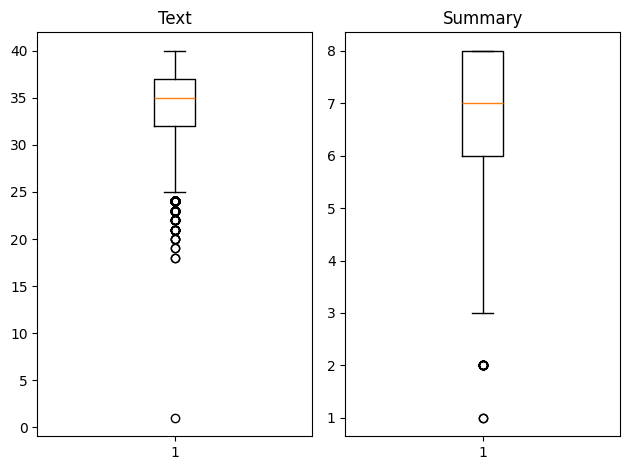

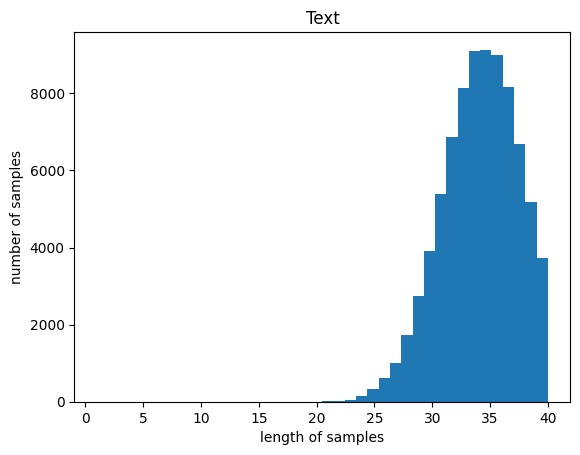

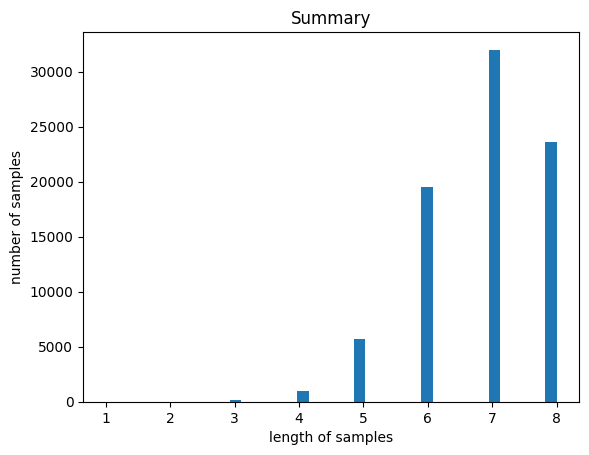

In [31]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

print('텍스트의 표준편차 : {}'.format(np.std(text_len)))
print('요약 표준편차: {}'.format(np.std(summary_len)))

# 텍스트와 요약 각각에 대해 maxlen 설정
text_max_tokens = np.mean(text_len) + 2 * np.std(text_len)  # 평균 + 2 * 표준편차
summary_max_tokens = np.mean(summary_len) + 2 * np.std(summary_len)

# 길이를 정수로 변환
text_maxlen = int(text_max_tokens)
summary_maxlen = int(summary_max_tokens)

print('text_maxlen  : ', text_maxlen)
print('summ_maxlen  : ', summary_maxlen)


plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [51]:
# 이로부터 Text의 최대 길이와 Summary의 적절한 최대 길이를 임의로 정해볼게요.
text_max_len = 38
summary_max_len = 7
print('=3')

=3


In [52]:
"""각각 50과 8로 정했는데 이 길이를 선택했을 때, 얼마나 많은 샘플들을 자르지 않고 포함할 수 있는지 통계로 확인하는 편이 객관적으로 길이를 결정하는 데 도움이 될거예요.
훈련 데이터와 샘플의 길이를 입력하면, 데이터의 몇 %가 해당하는지 계산하는 함수를 만들어서 좀 더 정확하게 판단해볼게요."""

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')


=3


In [53]:
#이렇게 만든 함수를 Text와 Summary에 적용해 우리가 결정한 임의의 길이가 몇%의 샘플까지 포함하는지 볼 수 있겠죠.
below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len,  data['Summary'])


전체 샘플 중 길이가 38 이하인 샘플의 비율: 0.8911465007016901
전체 샘플 중 길이가 7 이하인 샘플의 비율: 0.7117822930014034


In [54]:
# E! Q. Text와 Summary를 담고 있는 data 데이터프레임을 위에서 임의로 정의한 text_max_len과 summary_max_len의 길이보다 큰 샘플을 제외하는 코드를 작성하세요.
# (힌트 : apply 함수와 lamda식을 사용)


# 조건에 맞지 않는 샘플 제거 Text 60, summary 8 기준 초과는 삭제
data = data[
    (data['Text'].apply(lambda x: len(x.split())) <= text_max_len) &
    (data['Summary'].apply(lambda x: len(x.split())) <= summary_max_len)
]

# 결과 확인
print(f"Filtered data shape: {data.shape}")

Filtered data shape: (52766, 4)


In [55]:
# 디코더는 시작 토큰을 입력받아 문장을 생성하기 시작하고, 종료 토큰을 예측한 순간에 문장 생성을 멈추는 거였죠.
"""seq2seq 훈련을 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가할 필요가 있어요.
이번 실습에서는 시작 토큰은 sostoken, 종료 토큰은 eostoken이라 임의로 명명하고 앞, 뒤로 추가할 거예요.
디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름을 decoder_input,
디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름을 decoder_target이라고 이름을 정했어요.
두 개의 문장 모두 Summary 열로부터 만들 거예요."""

# 요약Summary 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x) # sos토큰을 맨앞에, 모든 열에 추가
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken') # eos토큰을 맨뒤에
data.head()


<ipython-input-55-eda303c6b1df>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x) # sos토큰을 맨앞에, 모든 열에 추가
<ipython-input-55-eda303c6b1df>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken') # eos토큰을 맨뒤에


,Summary,Text,decoder_input,decoder_target
1,known hirani yrs metoo claims true sonam,speaking sexual harassment allegations rajkuma...,sostoken known hirani yrs metoo claims true sonam,known hirani yrs metoo claims true sonam eostoken
2,india get lowest odi total new zealand,india recorded lowest odi total new zealand ge...,sostoken india get lowest odi total new zealand,india get lowest odi total new zealand eostoken
5,cousins fed human excreta friendship boys,two minor cousins uttar pradesh gorakhpur alle...,sostoken cousins fed human excreta friendship ...,cousins fed human excreta friendship boys eost...
6,ram krishna smoke ramdev sadhus kumbh,urging saints seers kumbh mela quit smoking yo...,sostoken ram krishna smoke ramdev sadhus kumbh,ram krishna smoke ramdev sadhus kumbh eostoken
7,cried bidaai felt peer pressure isha ambani,reliance industries chairman mukesh ambani dau...,sostoken cried bidaai felt peer pressure isha ...,cried bidaai felt peer pressure isha ambani eo...


In [56]:
# 앞뒤로 토큰이 잘 붙었죠? 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장해 줄게요.
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


In [57]:

indices = np.arange(encoder_input.shape[0]) # 인코더 인풋 데이터 수만큼 인덱스 생성
np.random.shuffle(indices) # 인덱스를 무작위로 섞어 데이터 순서 랜덤화
print(indices)

[34170 14510 22631 ... 50981 25922 39824]


In [58]:
# 이 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의해 주면 잘 섞인 샘플이 되겠죠.
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

#이제 섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리해 줄게요.
#전체 데이터의 크기에서 0.2를 곱해서 테스트 데이터의 크기를 정의해 줄게요.
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

# 나는 text maxlen을 60으로 설정 -> 노드와 차이

=3
테스트 데이터의 수 : 10553
훈련 데이터의 개수 : 42213
훈련 레이블의 개수 : 42213
테스트 데이터의 개수 : 10553
테스트 레이블의 개수 : 10553


In [59]:
"""이제 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 바꾸어 주어야 해요.
이를 위해서는 각 단어에 고유한 정수를 맵핑하는 작업이 필요해요. 이 과정을 단어 집합(vocabulary) 을 만든다고 표현해요.
훈련 데이터에 대해서 단어 집합을 만들어볼게요. 우선, 원문에 해당되는 encoder_input_train에 대해서 단어 집합을 만들게요.
Keras의 토크나이저를 사용하면, 입력된 훈련 데이터로부터 단어 집합을 만들 수 있어요."""
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


In [60]:
"""이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었어요. 현재 생성된 단어 집합은 src_tokenizer.word_index에 저장되어 있어요.
그런데 우리는 이렇게 만든 단어 집합에 있는 모든 단어를 사용하는 것이 아니라, 빈도수가 낮은 단어들은 훈련 데이터에서 제외하고 진행하려고 해요.
등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해볼게요.
src_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장돼 있는데, 이를 통해서 통계적인 정보를 얻을 수 있어요."""

threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 각단어 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


단어 집합(vocabulary)의 크기 : 51541
등장 빈도가 6번 이하인 희귀 단어의 수: 35666
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 15875
단어 집합에서 희귀 단어의 비율: 69.19927824450437
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.175296400512738


In [61]:
src_vocab = 15000 # 단어 집합 크기 제한 (Tokenizer(num_words=src_vocab)),
                 # src_vocab을 9,000으로 설정하면, 빈도 순위 상위 9,000개의 단어만 단어 집합에 포함됩니다.
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 (나는 9,000으로 제한)
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성, 등장 빈도가 낮아 순위에서 밀린 희귀 단어들은 자동으로 단어 집합에서 제외됩니다.
print('=3')



=3


In [62]:
"""texts_to_sequences()는 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행해요.
현재 단어 집합의 크기를 8,000으로 제한했으니까 이제 9,000이 넘는 숫자들은 정수 인코딩 후에는 데이터에 존재하지 않아요."""
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])



[[96, 24, 14712, 584, 3, 17, 204, 469, 913, 1535, 2918, 811, 350, 131, 754, 204, 1725, 144, 28, 3, 477, 230, 9018, 2223, 1429, 144, 363, 515, 1953, 174, 1345, 3848], [54, 4179, 4398, 4664, 246, 65, 14, 42, 19, 267, 159, 92, 1288, 54, 7164, 1259, 4, 1954, 1991, 2, 54, 10101, 14713, 704, 10, 246, 107, 14714, 1551], [110, 2919, 86, 51, 2367, 3557, 1773, 2972, 163, 520, 126, 50, 423, 370, 169, 520, 4399, 1, 2475, 608, 7363, 443, 803, 4399, 2, 520, 262, 85, 2920, 2919, 5994, 2404]]


In [63]:
# Summary 데이터에 대해서도 동일한 작업을 수행할게요.
# 케라스의 토크나이저를 사용하여 decoder_input_train을 입력으로 전체 단어 집합과 각 단어에 대한 빈도수를 계산해요.
tar_tokenizer = Tokenizer() # 토크나이저 정의
tar_tokenizer.fit_on_texts(decoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


In [64]:
"""이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었어요.
이는 tar_tokenizer.word_index에 저장되어 있어요. tar_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장돼 있는데,
이를 통해서 통계적인 정보를 얻어서, 등장 빈도수가 6회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해볼게요."""

threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

"""등장 빈도가 5회 이하인 단어들은 단어 집합에서 약 77%를 차지하고 있네요.
하지만 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 매우 적은 수치인 5.87%밖에 되지 않아요.
아까 했던 것과 동일하게 이 단어들은 모두 제거할게요. 어림잡아 2,000을 단어 집합의 크기로 제한할게요."""

단어 집합(vocabulary)의 크기 : 23088
등장 빈도가 5번 이하인 희귀 단어의 수: 16021
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 7067
단어 집합에서 희귀 단어의 비율: 69.39102564102564
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 9.82017015606181


'등장 빈도가 5회 이하인 단어들은 단어 집합에서 약 77%를 차지하고 있네요. \n하지만 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 매우 적은 수치인 5.87%밖에 되지 않아요. \n아까 했던 것과 동일하게 이 단어들은 모두 제거할게요. 어림잡아 2,000을 단어 집합의 크기로 제한할게요.'

In [65]:
tar_vocab = 7000
tar_tokenizer = Tokenizer(num_words=tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 79, 286, 256, 594, 59, 2140], [1, 3, 1296, 1489, 46, 209, 155], [1, 1584, 73, 2719, 1718, 1585, 124, 205], [1, 340, 79, 311, 259, 3443, 302, 4606], [1, 4319, 501, 2310, 1336, 465]]
target
decoder  [[79, 286, 256, 594, 59, 2140, 2], [3, 1296, 1489, 46, 209, 155, 2], [1584, 73, 2719, 1718, 1585, 124, 205, 2], [340, 79, 311, 259, 3443, 302, 4606, 2], [4319, 501, 2310, 1336, 465, 2]]


In [66]:
"""정상적으로 정수 인코딩 작업이 끝났어요.
현재 decoder_input_train과 decoder_target_train에는 더 이상 숫자 2,000이 넘는 숫자들은 존재하지 않아요.
그런데 다음 작업인 패딩 하기로 넘어가기 전에 한 가지 점검해야 할 것이 있어요.

전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었을 가능성이 있어요.
이 현상은 길이가 상대적으로 길었던 원문(Text)의 경우에는 문제가 별로 없겠지만,
애초에 평균 길이가 4밖에 되지 않았던 요약문(Summary)의 경우에는 이 현상이 굉장히 두드러졌을 가능성이 높겠죠.

요약문에서 길이가 0이 된 샘플들의 인덱스를 받아와볼게요.
여기서 주의할 점은 요약문인 decoder_input에는 sostoken 또는 decoder_target에는 eostoken이 추가된 상태이고,
이 두 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플 수와 동일하게 매우 높으므로 단어 집합 제한에도 삭제되지 않아요.
그래서 이제 길이가 0이 된 요약문의 실제 길이는 1로 나올 거예요.
길이 0이 된 decoder_input에는 sostoken, decoder_target에는 eostoken만 남아 있을 테니까요.

훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장해볼게요.
이 샘플들은 모두 삭제할 거예요."""

drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]
# enumerate()는 반복 가능한 객체(예: 리스트, 튜플, 문자열 등)에 대해 인덱스와 값을 동시에 반환합니다.
# -> decoder_input_train에서 각 문장(sentence)과 해당 문장의 인덱스(index)를 반환

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))



삭제할 훈련 데이터의 개수 : 4
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 42209
훈련 레이블의 개수 : 42209
테스트 데이터의 개수 : 10553
테스트 레이블의 개수 : 10553


In [67]:
"""텍스트 시퀀스를 정수 시퀀스로 변환했다면, 이제 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업을 해주어야 해야 해요.
아까 정해두었던 최대 길이로 패딩 해 줄 거에요. 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이를 맞춰줄게요."""
# Text maxlen 나는 60
# summary maxlen 나는 8

encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')
print('=3')

# 이제 학습에 필요한 데이터 전처리가 모두 끝났어요.


=3


Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

In [63]:
!nvidia-smi

Tue Nov 26 07:45:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   75C    P0              35W /  72W |  21207MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [68]:
# 함수형 API를 이용해서 인코더를 설계해 볼게요.
# Q.인코더 LSTM 1을 참고해서 나머지 인코더의 LSTM 2, LSTM 3의 코드를 완성하세요.

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 200
hidden_size = 256 # LSTM의 뉴런 수, 출력 차원.

# 인코더
encoder_inputs = Input(shape=(text_max_len,)) #입력 형태: (batch_size, text_max_len)에서 batch_size는 가변적이고 text_max_len은 고정된 시퀀스 길이입니다.

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)
""" Embedding: 입력 단어를 고정된 차원의 실수 벡터로 변환합니다.
	•	src_vocab: 단어 집합 크기. 입력 단어를 src_vocab 내에서 정수로 인코딩합니다.
	•	embedding_dim: 각 단어를 표현하는 벡터의 차원.
	•	출력:
	•	(batch_size, text_max_len, embedding_dim) 형태의 텐서를 반환합니다.
	•	즉, 각 단어가 embedding_dim 크기의 벡터로 변환됩니다."""

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.1)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)
"""	•	hidden state와 cell state를 사용하여 시퀀스 데이터를 학습.
	•	hidden state: 현재 시점에서의 단기 기억.
	•	cell state: 장기 기억으로 이전 스텝의 중요한 정보 보존.
  •	return_sequences=True: 모든 time step의 출력을 반환.
	•	return_state=True: 마지막 hidden state와 cell state를 반환.

  •	출력:
	•	encoder_output1: (batch_size, text_max_len, hidden_size) 크기의 텐서.
	•	state_h1: (batch_size, hidden_size) 크기의 텐서. 마지막 스텝의 hidden state.
	•	state_c1: (batch_size, hidden_size) 크기의 텐서. 마지막 스텝의 cell state.
"""

# 인코더의 LSTM 2
# [[YOUR CODE]]
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.1)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) # LSTM 1의 출력인 encoder_output1을 입력으로 받습니다.

# 인코더의 LSTM 3
# [[YOUR CODE]]
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.1)
encoder_output3, state_h3, state_c3 = encoder_lstm3(encoder_output2)
"""	•	return_sequences=False: 모든 time step의 출력이 아닌 마지막 time step의 출력만 반환.
	•	역할:
	•	컨텍스트 벡터(Context Vector)로 사용할 마지막 출력만 반환하여 디코더에 전달.
	•	출력:
	•	encoder_output3: (batch_size, hidden_size) 크기의 텐서. 마지막 스텝의 출력. 디코더에 전달되는 컨텍스트 벡터.
	•	state_h3: 마지막 스텝의 hidden state.디코더 초기 상태로 사용.
	•	state_c3: 마지막 스텝의 cell state. 디코더 초기 상태로 사용.
  """
"""인코더의 LSTM은 총 3개의 층으로 구성해서 모델의 복잡도를 높였어요.
hidden state의 크기를 늘리는 것이 LSTM 층 1개의 용량을 늘린다면, 3개의 층을 사용하는 것은 모델의 용량을 늘린다고 볼 수 있죠.
3개의 층을 지나서 인코더로부터 나온 출력 벡터는 디코더로 보내줘야겠죠?
"""



'인코더의 LSTM은 총 3개의 층으로 구성해서 모델의 복잡도를 높였어요. \nhidden state의 크기를 늘리는 것이 LSTM 층 1개의 용량을 늘린다면, 3개의 층을 사용하는 것은 모델의 용량을 늘린다고 볼 수 있죠. \n3개의 층을 지나서 인코더로부터 나온 출력 벡터는 디코더로 보내줘야겠죠?\n'

- 주의, 어텐션 메커니즘은 return_sequences=True로 해야함을 노드 학습시 알게되어, 프로젝트에서는 True로 적용함을 주의하였습니다.

In [69]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim) # tar_vocab: 디코더(목적어)의 단어 집합 크기.
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
# 	디코더 LSTM은 한 시점에서 다음 단어를 예측하기 위해 현재 시점의 입력과 이전 시점의 정보를 활용.

decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h3, state_c3])
"""	•	인코더에서 전달된 마지막 hidden state와 cell state를 디코더 초기 상태로 사용.
	•	이를 통해 인코더에서 추출한 입력 시퀀스의 요약 정보(컨텍스트)를 디코더가 사용할 수 있음.

  •	출력:
	•	decoder_outputs: 모든 time step의 출력. (batch_size, timesteps, hidden_size).
	•	_: 디코더의 마지막 hidden state.
	•	_: 디코더의 마지막 cell state"""

'\t•\t인코더에서 전달된 마지막 hidden state와 cell state를 디코더 초기 상태로 사용.\n\t•\t이를 통해 인코더에서 추출한 입력 시퀀스의 요약 정보(컨텍스트)를 디코더가 사용할 수 있음.\n  \n  •\t출력:\n\t•\tdecoder_outputs: 모든 time step의 출력. (batch_size, timesteps, hidden_size).\n\t•\t_: 디코더의 마지막 hidden state.\n\t•\t_: 디코더의 마지막 cell state'

In [70]:

"""디코더의 임베딩 층과 LSTM을 설계하는 것은 인코더와 거의 동일해요.
하지만 LSTM의 입력을 정의할 때, initial_state의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어줘야 해요.
디코더의 출력층을 설계해볼게요."""

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)
"""•	Dense 레이어:
	•	Fully connected layer로 각 time step에서 단어 집합의 크기만큼 출력을 생성.
	•	각 출력은 단어 집합에서 특정 단어의 확률로 표현.
	•	매개변수:
	•	tar_vocab: 디코더 단어 집합의 크기.
	•	activation='softmax': 다중 클래스 분류를 위해 softmax 활성화 함수 사용.
	•	출력:
	•	decoder_softmax_outputs: (batch_size, timesteps, tar_vocab) 형태의 텐서.
	•	각 time step마다 단어 집합 내에서 특정 단어의 확률 분포를 반환."""

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)


In [71]:
"""어텐션 메커니즘
어텐션 메커니즘을 수행하는 어텐션 함수를 설계하는 것은 또 다른 새로운 신경망을 설계해야 한다는 뜻이에요. 어텐션 함수를 설계해보는 것은 다음 기회로 미루기로 하고, 여기서는 TensorFlow에 이미 구현된 어텐션 함수를 가져와서 디코더의 출력층에 어떤 방식으로 결합하는지 배워볼게요. 참고로 여기서 사용하는 어텐션 함수는 Bahdanau 스타일의 어텐션입니다. 이 어텐션에 대한 자세한 설명은 텐서플로우 홈페이지를 참고하세요.
아래와 같이 어텐션 층을 만들고, 위에서 설계한 디코더의 출력층을 수정해 봅시다."""

from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_output3]) #인코더 LSTM 마지막 층 output가져오기
"""	•	attn_layer는 디코더의 출력(decoder_outputs)과 인코더의 출력(encoder_outputs)을 입력받아, 디코더의 각 time step에 대한 컨텍스트 벡터를 계산합니다.
	•	계산 과정:
	1.	디코더 hidden state와 인코더 hidden state 간의 **유사도(가중치)**를 계산.
	2.	Softmax를 통해 가중치를 정규화.
	3.	인코더 hidden state의 가중합을 계산하여 컨텍스트 벡터를 생성."""


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])
"""	•	Concatenate를 사용하여 디코더의 hidden state와 어텐션 컨텍스트 벡터를 연결합니다.
	•	이 연결된 벡터는 디코더의 다음 출력층으로 전달되어 예측을 수행합니다."""


# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)
"""	•	Dense(tar_vocab, activation='softmax'):
	•	목표 단어 집합의 크기(tar_vocab)에 맞는 출력층을 생성합니다.
	•	Softmax 활성화 함수는 각 출력 단어에 대한 확률 분포를 생성합니다.
	•	입력: 연결된 벡터 (decoder_concat_input).
	•	출력: 디코더가 다음 단어를 예측하기 위한 확률 분포."""


# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()


#위의 코드는 인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용하고,
#어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동하고 있어요.
"""
주요 흐름 요약

	1.	인코더:
	•	입력 텍스트를 임베딩 → LSTM → 모든 hidden state (encoder_outputs) 생성.
	2.	디코더:
	•	이전 단어(디코더 입력)를 기반으로 hidden state(decoder_outputs) 생성.
	3.	어텐션 적용:
	•	디코더 hidden state와 인코더 hidden state를 비교하여 컨텍스트 벡터 생성.
	•	컨텍스트 벡터와 디코더 hidden state를 연결하여 최종 입력 구성.
	4.	출력층:
	•	연결된 벡터를 통해 다음 단어를 예측하는 Softmax 출력 생성."""



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 38)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 38, 200)        │      3,000,000 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 38, 256),      │        467,968 │ embedding[0][0]        │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 38, 256),      │        525,312 │ lstm[0][0]             │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 200)      │      1,400,000 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, 38, 256),      │        525,312 │ lstm_1[0][0]           │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ [(None, None, 256),    │        467,968 │ embedding_1[0][0],     │
│                           │ (None, 256), (None,    │                │ lstm_2[0][1],          │
│                           │ 256)]                  │                │ lstm_2[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer           │ (None, None, 256)      │            256 │ lstm_3[0][0],          │
│ (AdditiveAttention)       │                        │                │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concat_layer              │ (None, None, 512)      │              0 │ lstm_3[0][0],          │
│ (Concatenate)             │                        │                │ attention_layer[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, None, 7000)     │      3,591,000 │ concat_layer[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 9,977,816 (38.06 MB)

 Trainable params: 9,977,816 (38.06 MB)

 Non-trainable params: 0 (0.00 B)

'\n주요 흐름 요약\n\n\t1.\t인코더:\n\t•\t입력 텍스트를 임베딩 → LSTM → 모든 hidden state (encoder_outputs) 생성.\n\t2.\t디코더:\n\t•\t이전 단어(디코더 입력)를 기반으로 hidden state(decoder_outputs) 생성.\n\t3.\t어텐션 적용:\n\t•\t디코더 hidden state와 인코더 hidden state를 비교하여 컨텍스트 벡터 생성.\n\t•\t컨텍스트 벡터와 디코더 hidden state를 연결하여 최종 입력 구성.\n\t4.\t출력층:\n\t•\t연결된 벡터를 통해 다음 단어를 예측하는 Softmax 출력 생성.'

In [72]:
# 모델 훈련
from tensorflow.keras.callbacks import ModelCheckpoint

# 최적 모델 저장 경로 설정
checkpoint_filepath1 = 'best_model1.keras'

# ModelCheckpoint 콜백 정의
mc = ModelCheckpoint(filepath=checkpoint_filepath1,  # 저장 경로
                     monitor='val_loss',           # 모니터링할 기준 지표
                     save_best_only=True,          # 최상의 모델만 저장
                     verbose=1)                    # 진행 상황 표시

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

history1 = model.fit(x=[encoder_input_train, decoder_input_train],
                    y=decoder_target_train,
                    validation_data=([encoder_input_test, decoder_input_test],
                    decoder_target_test),
                    callbacks=[mc],  # 콜백 추가
                    batch_size=256, epochs=40)

# 추후사용
                    # batch_size=256, callbacks=[es], epochs=50)

Epoch 1/40
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 7.1186
Epoch 1: val_loss improved from inf to 6.26325, saving model to best_model1.keras
165/165 ━━━━━━━━━━━━━━━━━━━━ 33s 160ms/step - loss: 7.1158 - val_loss: 6.2633
Epoch 2/40
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 6.3483
Epoch 2: val_loss improved from 6.26325 to 6.07872, saving model to best_model1.keras
165/165 ━━━━━━━━━━━━━━━━━━━━ 26s 159ms/step - loss: 6.3481 - val_loss: 6.0787
Epoch 3/40
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 6.0759
Epoch 3: val_loss improved from 6.07872 to 5.68176, saving model to best_model1.keras
165/165 ━━━━━━━━━━━━━━━━━━━━ 27s 161ms/step - loss: 6.0754 - val_loss: 5.6818
Epoch 4/40
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 5.6032
Epoch 4: val_loss improved from 5.68176 to 5.37002, saving model to best_model1.keras
165/165 ━━━━━━━━━━━━━━━━━━━━ 27s 163ms/step - loss: 5.6028 - val_loss: 5.3700
Epoch 5/40
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 5.2006
Epo

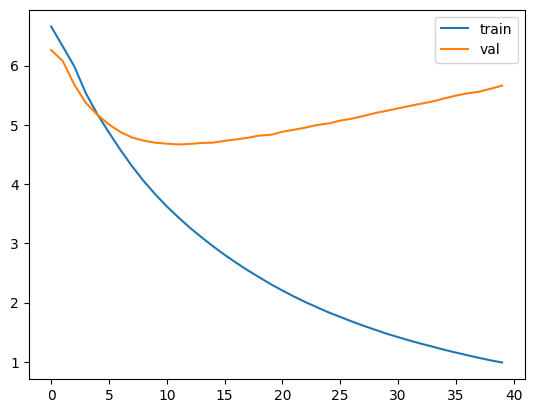

In [73]:
# 이제 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화 해봐요.
plt.plot(history1.history['loss'], label='train')
plt.plot(history1.history['val_loss'], label='val')
plt.legend()
plt.show()

11.26 회고
1. csv 파일 저장 경로를 앞으로 꼼꼼히 체크하면서 할것..
2. 마저 하지 못한부분은 저녁에 이어서 해놓겠습니다. 죄송합니다 리뷰어님!!

인퍼런스 모델 구현

In [ ]:
# 인퍼런스 모델 구현
# 테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 필요한 3개의 사전을 아래와 같이 미리 준비해 둡니다.
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

In [ ]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_output3, state_h3, state_c3])
"""	•	인코더의 출력:
	•	encoder_output3: 인코더의 모든 타임스텝에서 생성된 hidden state들. 그림에서 Hidden으로 표현된 벡터들.
	•	state_h3: 인코더의 마지막 타임스텝에서 나온 hidden state.
	•	state_c3: 인코더의 마지막 타임스텝에서 나온 cell state.
	•	이 출력은 디코더와 어텐션 메커니즘의 입력으로 전달됩니다."""

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))
"""	•	디코더 초기 상태로 전달되는 녹색 블록의 초기 값( h^d_1, c^d_1 )에 해당합니다."""

dec_emb2 = dec_emb_layer(decoder_inputs)
"""	•	학습 단계에서 정의된 디코더 임베딩 층(dec_emb_layer)를 그대로 재사용합니다.
	•	decoder_inputs: 디코더의 입력 시퀀스. 이는 인퍼런스 단계에서 반복적으로 한 단어씩 입력됩니다.

	설명:
	•	디코더에 들어가는 입력 단어 시퀀스는 먼저 임베딩층(dec_emb_layer)을 통해 임베딩 벡터로 변환됩니다.
	•	이 단계는 입력 단어를 실수 벡터 공간으로 변환하여 LSTM에 전달합니다.
	•	그림에서:
	•	디코더의 파란색 Input 블록이 임베딩을 통해 녹색 블록(LSTM의 입력)으로 변환되는 과정에 해당합니다.
"""


# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])
"""	•	학습 단계와 동일하게 디코더 LSTM(decoder_lstm)을 사용하되, **초기 상태(initial_state)**로 이전 시점의 hidden state와 cell state를 전달합니다.
	•	출력 정의:
	•	decoder_outputs2: 디코더의 현재 타임스텝 출력. 인퍼런스 단계에서 다음 단어를 예측하기 위한 logits 값으로 사용됩니다.
	•	state_h2, state_c2: 디코더 LSTM의 현재 시점 hidden state와 cell state. 다음 타임스텝에서 디코더의 초기 상태로 사용됩니다.
	•	설명:
	•	디코더의 LSTM은 현재 입력값(dec_emb2)과 초기 상태([decoder_state_input_h, decoder_state_input_c])를 기반으로 다음 Hidden State ( h^d )와 Cell State ( c^d )를 계산합니다.
	•	출력값 decoder_outputs2는 디코더의 각 타임스텝에서 출력된 Hidden State의 시퀀스( h^d_1, h^d_2, …, h^d_t )입니다.
	•	상태값 state_h2와 state_c2는 디코더의 마지막 Hidden State와 Cell State입니다.
	•	그림에서:
	•	디코더의 녹색 블록에서 생성된 Hidden State ( h^d_1, h^d_2, …, h^d_t )를 나타냅니다.
	•	state_h2와 state_c2는 마지막 녹색 블록의 상태입니다.

"""
print('=3')

In [ ]:
# 어텐션 메커니즘을 사용하는 출력층을 설계해 주세요.

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))

attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
"""	•	attn_layer: 학습 단계에서 사용된 어텐션 층(AdditiveAttention)을 재사용합니다.
	•	입력:
	•	decoder_outputs2: 디코더의 현재 타임스텝 hidden state.
	•	decoder_hidden_state_input: 인코더의 모든 타임스텝 hidden state.
	•	출력:
	•	attn_out_inf: 어텐션 메커니즘을 통해 계산된 컨텍스트 벡터(context vector). 이는 디코더의 현재 타임스텝에서 중요한 인코더의 hidden state 정보를 가중합으로 제공합니다.
  최종
  이 코드는 디코더의 출력 Hidden State(decoder_outputs2)와 인코더의 Hidden State 전체(decoder_hidden_state_input)를 입력으로 받아, 디코더의 현재 타임스텝에 맞는 컨텍스트 벡터를 계산합니다.
	•	decoder_outputs2:
	•	디코더의 각 타임스텝별 Hidden State의 출력 시퀀스.
	•	모양: (batch_size, target_seq_len, hidden_size)
	•	예를 들어, 디코더가 3개의 타임스텝을 수행했다면:
  decoder_outputs2 = [h_d1, h_d2, h_d3]
  	decoder_hidden_state_input:
	•	인코더의 모든 타임스텝의 Hidden State 출력 시퀀스.
	•	모양: (batch_size, input_seq_len, hidden_size)
	•	예를 들어, 인코더의 입력이 5개 단어라면:
  decoder_hidden_state_input = [h_1, h_2, h_3, h_4, h_5]
	1.	가중치 계산 (Attention Weights):. 	2.	가중합 계산 (Weighted Sum):
	•	입력:
	1.	디코더의 Hidden State 시퀀스 (decoder_outputs2).
	2.	인코더의 Hidden State 시퀀스 (decoder_hidden_state_input).
	•	출력:
	•	디코더의 각 타임스텝에서 계산된 컨텍스트 벡터들의 시퀀스 (attn_out_inf).
	•	모양: (batch_size, target_seq_len, hidden_size)
	•	예: 만약 디코더가 3개의 타임스텝을 수행했다면:
  attn_out_inf = [z^e_1, z^e_2, z^e_3]
"""

decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

In [ ]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq, e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])

        # 예외 처리: KeyError 방지
        sampled_token = tar_index_to_word.get(sampled_token_index, '<UNK>')  # 없는 경우 <UNK>로 대체

        if sampled_token != 'eostoken':
            decoded_sentence += ' ' + sampled_token

        # 종료 조건: <EOS> 또는 최대 길이 초과
        if sampled_token == 'eostoken' or len(decoded_sentence.split()) >= (summary_max_len - 1):
            stop_condition = True

        # 타겟 시퀀스 업데이트
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 상태 업데이트
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
print(tar_word_to_index['sostoken'])  # 예: 1
print(tar_word_to_index['eostoken'])  # 예: 2

In [ ]:
"""테스트 단계에서는 정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인하는 것이 편하겠죠.
주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수를 만들어볼게요.
함수를 만들 때, Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외하고

Summary의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외하도록 만들 거예요.

Q. seq2text 함수처럼 요약문의 정수 시퀀스를 텍스트로 변환하는 seq2summary 함수 코드를 작성하세요.
(힌트 : 요약문에는 sostoken과 eostoken을 고려해야 함)"""

# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq: # input_seq 리스트 순회
        if (i!=0):
            temp = temp + src_index_to_word[i]+' ' # src_index 사전에서 텍스트 가져온뒤 한칸 띄기
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
# def seq2summary(input_seq):
#     # [[YOUR CODE]]
#     temp_sum=''
#     for i in input_seq:
#         if (i!=0 & i!=1 & i!=2 ):
#             temp_sum = temp_sum + tar_index_to_word[i]+' '
#     return temp_sum

#2차
# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp = ''
    for i in input_seq:  # input_seq 리스트 순회
        # 0, 시작 토큰(sostoken), 종료 토큰(eostoken)은 제외
        if (i != 0 and i != tar_word_to_index['sostoken'] and i != tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '  # 요약문의 단어 사전 사용
    return temp.strip()  # 불필요한 공백 제거


print('=3')





실제결과 요약문 비교

In [ ]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

summa 추출적 요약

In [ ]:
import requests
from summa.summarizer import summarize

Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.

Step 5. Summa을 이용해서 추출적 요약해보기
추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

Summa의 summarize를 사용하여 추출적 요약을 해보세요.